# Preparation

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [13]:
import STAGATE

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [15]:
section_id = '151675'

In [16]:
input_dir = os.path.join('Data/Tutorial6', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [17]:
adata

AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [18]:
adata = adata[:,adata.var['total_counts']>100]
adata

View of AnnData object with n_obs × n_vars = 3592 × 10595
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [19]:
#Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [20]:
# read the annotation
Ann_df = pd.read_csv(os.path.join('Data/Turorial6', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [21]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

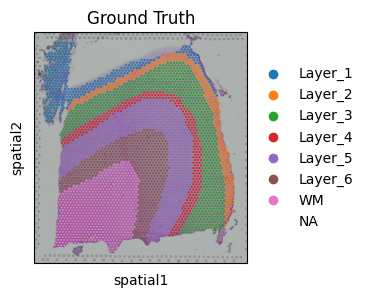

In [22]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

# Constructing the spatial network

------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.


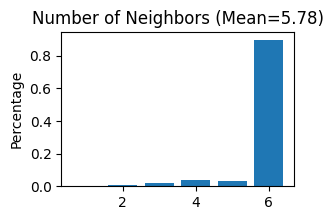

In [23]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

# Denoising expression using STAGATE

In [24]:
adata = STAGATE.train_STAGATE(adata, alpha=0, save_reconstrction=True)

Size of Input:  (3592, 10595)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2023-10-20 13:44:24.598186: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-10-20 13:44:24.616719: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2023-10-20 13:44:24.627752: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5590cd20cf00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-10-20 13:44:24.627785: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-10-20 13:44:24.629953: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-10-20 13:44:24.760342: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5590cfca7170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-20 13:44:24.760369: I tensorflow/compil

In [25]:
adata

AnnData object with n_obs × n_vars = 3592 × 10595
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'log1p', 'Ground Truth_colors', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'
    layers: 'STAGATE_ReX'

[<AxesSubplot:title={'center':'STAGATE_ATP2B4'}, xlabel='spatial1', ylabel='spatial2'>]

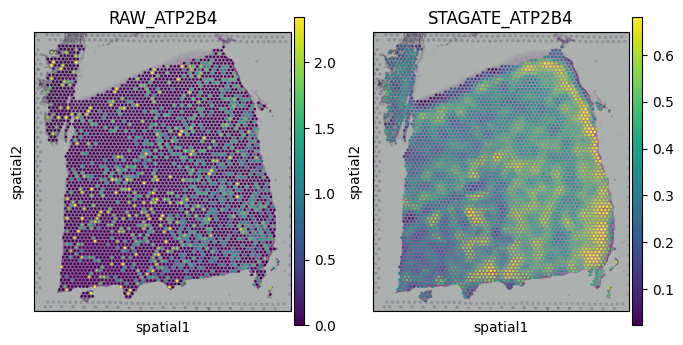

In [26]:
plot_gene = 'ATP2B4'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_RASGRF2'}, xlabel='spatial1', ylabel='spatial2'>]

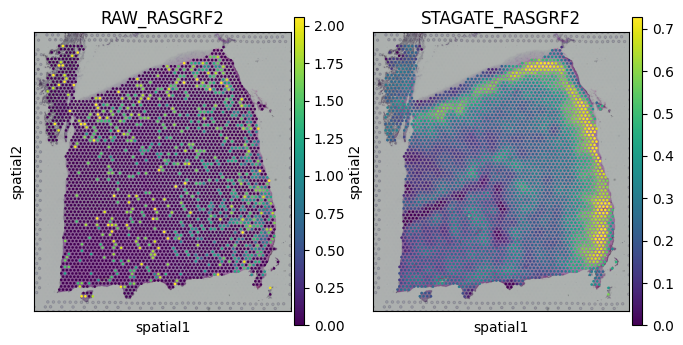

In [27]:
plot_gene = 'RASGRF2'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_LAMP5'}, xlabel='spatial1', ylabel='spatial2'>]

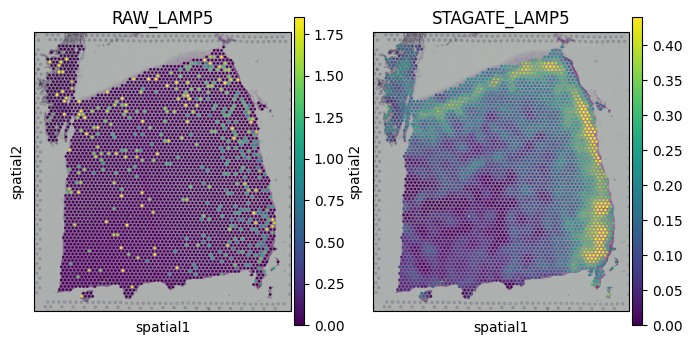

In [28]:
plot_gene = 'LAMP5'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_NEFH'}, xlabel='spatial1', ylabel='spatial2'>]

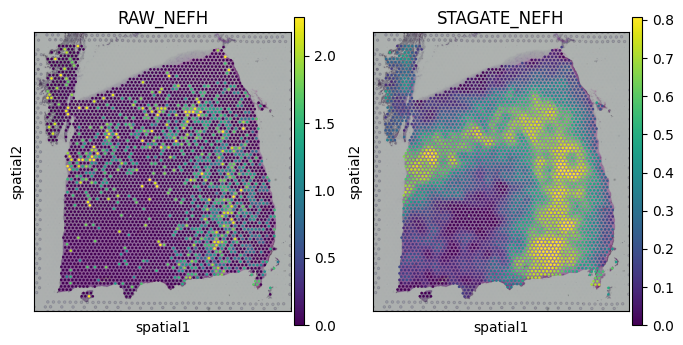

In [29]:
plot_gene = 'NEFH'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_NTNG2'}, xlabel='spatial1', ylabel='spatial2'>]

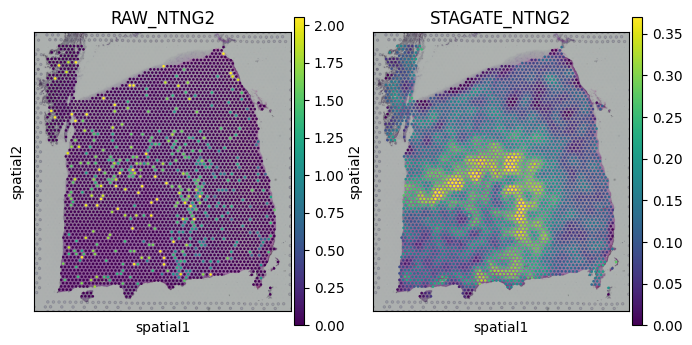

In [30]:
plot_gene = 'NTNG2'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')

[<AxesSubplot:title={'center':'STAGATE_B3GALT2'}, xlabel='spatial1', ylabel='spatial2'>]

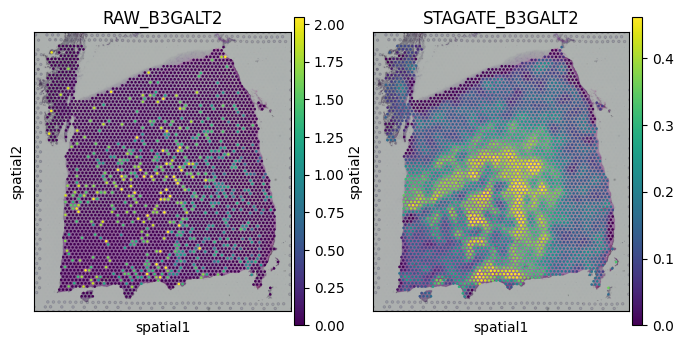

In [31]:
plot_gene = 'B3GALT2'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')